In [1]:
#|default_exp accel

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from accelerate import Accelerator


from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [3]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from diffusers import UNet2DModel


mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[xl]]

bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

In [5]:
dt = dls.train
xb,yb = next(iter(dt))

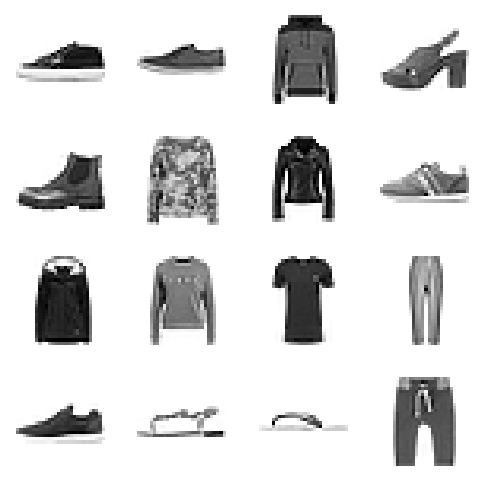

In [6]:
show_images(xb[:16], imsize=1.5)

In [7]:
betamin,betamax,n_steps = 0.0001,0.02,1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

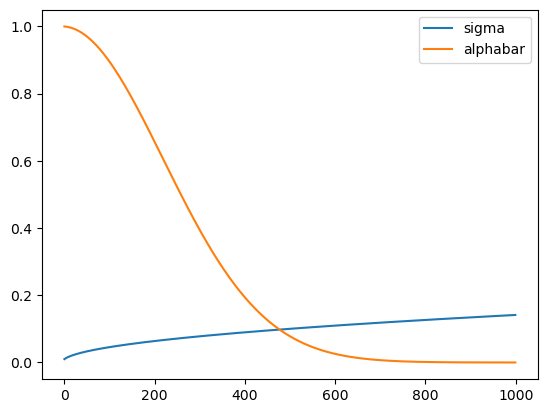

In [8]:
plt.plot(sigma);
plt.plot(alphabar);
plt.legend(('sigma', 'alphabar'))


In [9]:
# takes image and cumulative product for noise schedule
# returns noisified image, the time step used and the pure noise added
def noisify(x0, alphabar):
    device = x0.device
    n = len(x0) # number of samples
    t = torch.randint(0, n_steps, (n,), dtype=torch.long) # random timesteps in noise function. Higher means more noise (farther from original image)
    epislon = torch.randn(x0.shape, device=device) # noise
    alphabar_t = alphabar[t].reshape(-1, 1, 1, 1).to(device) # amount of noise to be included using cumulative product based on the timesteps
    xt = alphabar_t.sqrt()*x0 + (1-alphabar_t).sqrt()*epislon  # noisified image at timestep
    return xt, t.to(device), epislon

In [10]:
xt,t,epsilon = noisify(xb[:25],alphabar)
t

tensor([396, 741, 676, 890, 843, 231, 724, 813, 769, 434, 677, 822, 839, 273,
        626, 394, 118, 603, 684, 516, 635,  21, 645, 441,  33])

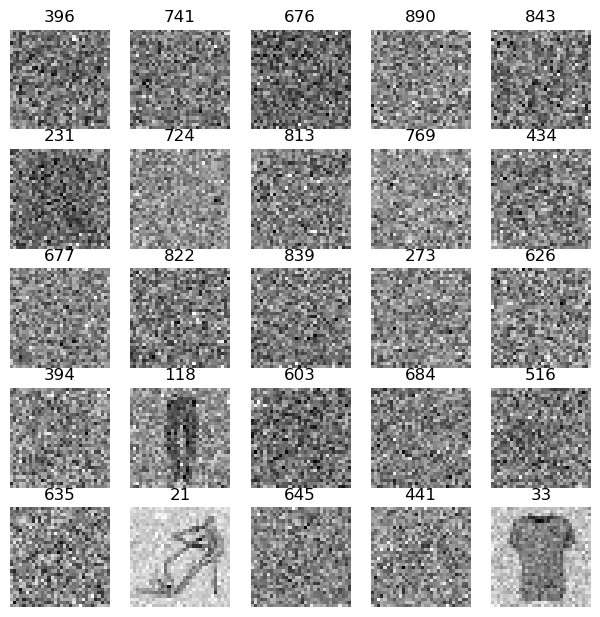

In [11]:
titles = fc.map_ex(t, '{}') # get timesteps as strings
show_images(xt, imsize=1.5, titles=titles)


In [12]:
#|export
class AccelerateCB(TrainCB):
    order = DeviceCB.order+10
    def __init__(self, n_inp=1, mixed_precision="fp16"):
        super().__init__(n_inp=n_inp)
        self.acc = Accelerator(mixed_precision=mixed_precision) # Hugging face accelerator. Using mixed precision here. Also handles device placement.
        
    def before_fit(self, learn):
        learn.model,learn.opt,learn.dls.train,learn.dls.valid = self.acc.prepare(
            learn.model, learn.opt, learn.dls.train, learn.dls.valid) # pass model, opt, train and valid into acclerator.  They now get wrapped by the accelerator

    def backward(self, learn): self.acc.backward(learn.loss) # Accelerator handles the backward step now when provided a loss.

In [13]:
# New collate function that will noisify the inputs
# This collate will only take the image from the dataset(label is ignored)
# it then returns 3 items, the image, the timestep and the noise
# That gives us a dataloader with two inputs
def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar) 
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)


In [14]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))


In [15]:
class DDPMCB2(Callback):
    def after_predict(self, learn): learn.preds = learn.preds.sample # This sample is required since we are using a hugging face unet

In [16]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [23]:
lr = 1e-2
epochs = 8
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
opt_func = partial(optim.Adam, eps=1e-5)
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
onMac = def_device == 'mps'
print(onMac)
trainer = TrainCB(n_inp=2) if onMac else AccelerateCB(n_inp=2)
print(trainer.__class__)
cbs = [DDPMCB2(), DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), trainer]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)


True
<class 'miniai.learner.TrainCB'>


In [20]:
learn.fit(epochs)

KeyboardInterrupt: 

In [24]:
learn.fit(epochs)

In [ ]:
# A trick to speed up loading data 
# Just repeat the same data twice to avoid loading new images as often
# Allows for more GPU utilization
class MultDL:
    def __init__(self, dl, mult=2): self.dl,self.mult = dl,mult
    def __len__(self): return len(self.dl)*self.mult
    def __iter__(self):
        for o in self.dl:
            for i in range(self.mult): yield o

dls.train = MultDL(dls.train)